<a href="https://colab.research.google.com/github/IPMoroz/data_science/blob/main/Project_4_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Проект: классификация

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [ ]:
# подключаем google диск, где у нас хранятся данные
from google.colab import drive
drive.mount('/content/drive')
# # берем необходимый нам файл с диска, указав путь
df = pd.read_csv('./drive/MyDrive/bank_fin.csv', sep = ';')
df.head()

Mounted at /content/drive


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [ ]:
# df = pd.read_csv('bank_fin.csv', sep = ';')

In [ ]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [ ]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### Задание 3

In [ ]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].apply(lambda x: np.NaN if x is np.NaN else float(x.replace('$', '').replace(',', '.').replace(' ', '')))
round(df['balance'].mean(), 3)

1529.129

### Задание 4

In [ ]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df = df.fillna({'balance':df['balance'].median()})
round(df['balance'].mean(), 3)

1526.936

### Задание 5

In [ ]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
df['job'] = df['job'].apply(lambda x: df['job'].mode()[0] if x=='unknown' else x)
df['education'] = df['education'].apply(lambda x: df['education'].mode()[0] if x=='unknown' else x)

mask1 = df['job'] == df['job'].value_counts().index[0]
mask2 = df['education'] == df['education'].value_counts().index[0]

round(df[mask1&mask2]['balance'].mean(), 3)

1598.883

### Задание 6

Text(0.5, 1.0, 'Статистика баланса')

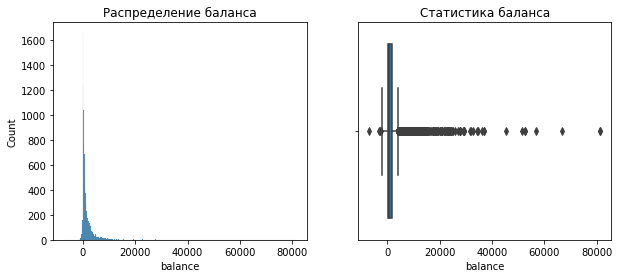

In [ ]:
# посмотрим распределение при помощи гистограммы и статистики баланса на ящике с усами
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
histplot = sns.histplot(data=df, x='balance', ax=axes[0]);
histplot.set_title('Распределение баланса')
boxplot = sns.boxplot(data=df, x='balance', ax=axes[1]);
boxplot.set_title('Статистика баланса')
# видно большое количество отклонений справа от границы коробчатой диаграммы, это основные кандидаты в выбросы
# распределение логнормальное, возможно после удаления выбросов картина изменится

In [ ]:
# удалите все выбросы для признака balance
# применим функцию outliers_iqr, добавив в вывод значения верхней и нижней границы
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>=lower_bound) & (x <= upper_bound)]
    return outliers, cleaned, lower_bound, upper_bound

outliers, cleaned, lower_bound, upper_bound = outliers_iqr(df, 'balance')

print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')
print(f'Верхняя граница: {round(upper_bound)}')
print(f'Нижняя граница: {round(lower_bound)}')

Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105
Верхняя граница: 4063
Нижняя граница: -2241


Text(0.5, 1.0, 'Статистика баланса')

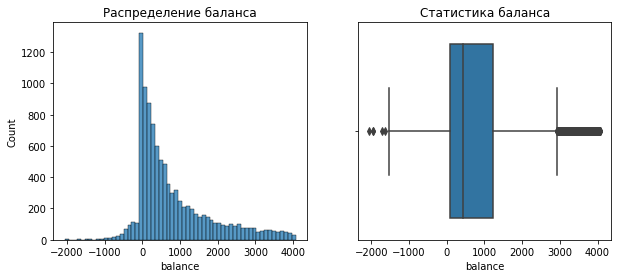

In [ ]:
# смотрим что получилось
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
histplot = sns.histplot(data=cleaned, x='balance', ax=axes[0]);
histplot.set_title('Распределение баланса')
boxplot = sns.boxplot(data=cleaned, x='balance', ax=axes[1]);
boxplot.set_title('Статистика баланса')
# распределение выровнялось, теперь оно больше похоже на нормальное
# коробка с усами приняла более равномерный вид

## Часть 2:  Разведывательный анализ

### Задание 1

no     5424
yes    4681
Name: deposit, dtype: int64

Text(0.5, 1.0, 'Соотношение целевой переменной')

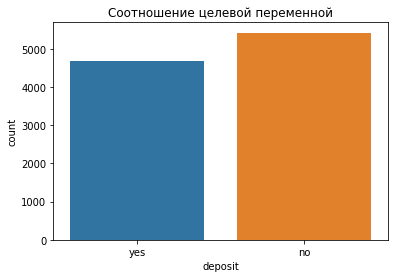

In [ ]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
display(cleaned['deposit'].value_counts())
countplot = sns.countplot(data=cleaned, x='deposit');
countplot.set_title('Соотношение целевой переменной')
# данные сбалансированны, соотношение примерно 54:46

### Задания 2 и 3

In [ ]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
cleaned.describe()
# средний возраст клиента 41 год, это примерно совпадает с медианой - скорее всего признак распределен нормально
# самый молодой и самый возрастной клиенты, соответственно 18 и 95 лет
# -1 пропущенный день с момента последней маркетинговой кампании до контакта в текущей кампании (pdays) вызывает у меня вопросы
# минимальная продолжительность разговора с клиентом банка 2 секунды
# день контакта в диапазоне от 1 до 31, похоже на правду
# balance, duration, pdays и previous скорее всего имеют отличное от нормального распределение, т.к. медиана заметно отличается от среднего

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


### Задания 4 и 5

In [ ]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
cleaned.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


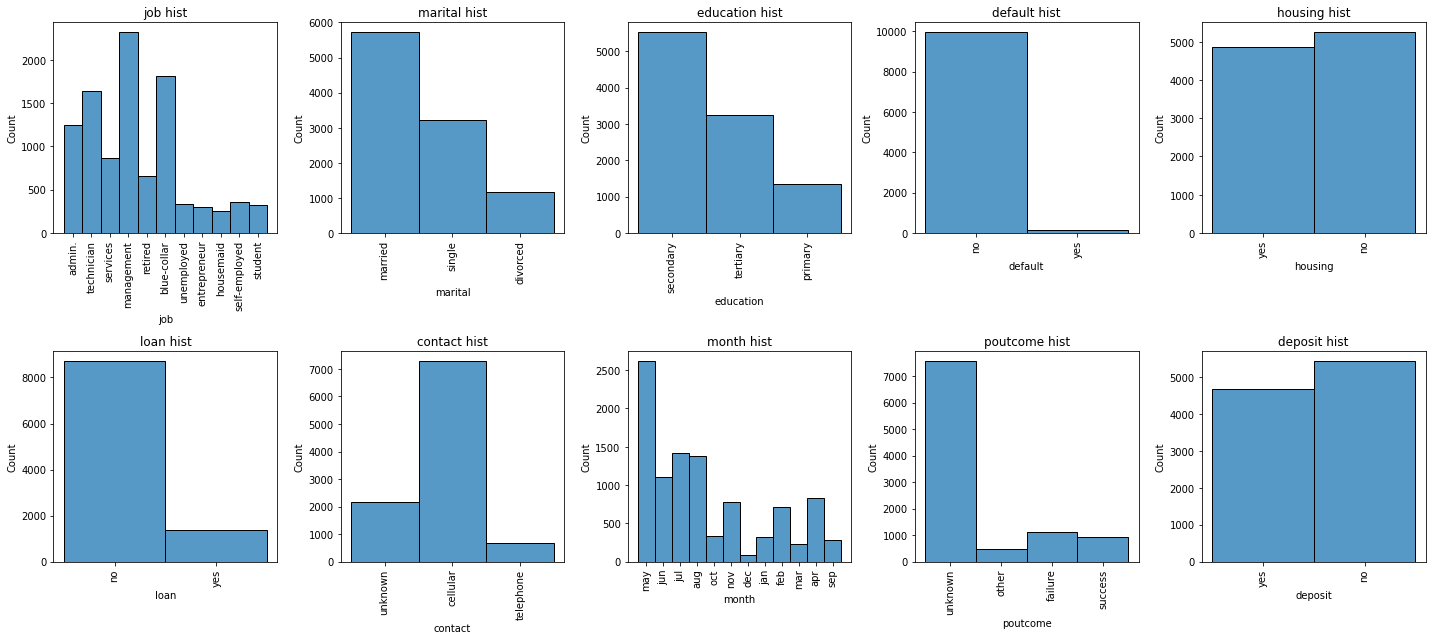

In [ ]:
#постройте визуализации, иллюстрирующие результаты
categorial_sign = list(cleaned.describe(include='object').columns)
n = len(categorial_sign)
fig, axes = plt.subplots(2, int(n/2), figsize=(20, 9))
for i, feature in enumerate(categorial_sign):
  if i<5:
    x=0
    y=i
  else:
    x=1
    y=i-5

  histplot = sns.histplot(data=cleaned, x=feature, ax=axes[x][y])
  histplot.set_title(f'{feature} hist')
  histplot.xaxis.set_tick_params(rotation=90)
plt.tight_layout()

- среди клиентов банка представлено всего 11 сфер занятости, самое распространенное - management (2315 случаев);

- маркетинговая кампания проходила каждый месяц, чаще всего в мае;

- чаще всего депозит в банке открывают женатые и со средним образованием;

- чаще с клиентом связывались по мобильному;

- большинство клиентов не имеют просроченной задолженности;

- неизвестные результаты прошлой маркетинговой кампании либо пропуски, либо новые клиенты по которым таких данных нет;

- большинство клиентов не брали кредиты на собственные нужды, а вот на жилье примерно пополам.

### Задание 6

In [ ]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
pout_dep = cleaned.groupby(['poutcome'])['deposit'].value_counts(normalize=True)
pout_dep

poutcome  deposit
failure   no         0.506763
          yes        0.493237
other     yes        0.550936
          no         0.449064
success   yes        0.911111
          no         0.088889
unknown   no         0.602642
          yes        0.397358
Name: deposit, dtype: float64

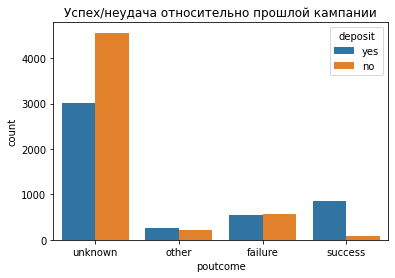

In [ ]:
countplot = sns.countplot(x='poutcome', hue='deposit', data=cleaned)
countplot.set_title('Успех/неудача относительно прошлой кампании');

### Задание 7

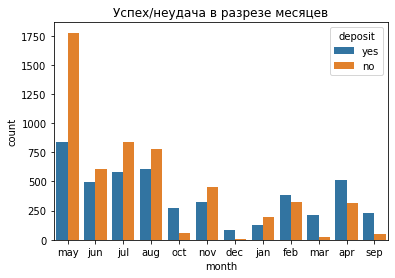

In [ ]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
month_dep = cleaned.groupby(['month'])['deposit'].value_counts(normalize=True)
countplot = sns.countplot(x='month', hue='deposit', data=cleaned)
countplot.set_title('Успех/неудача в разрезе месяцев');

### Задание 8

In [ ]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def age_groups(age):
  if age < 30:
    age = '<30'
  elif 30<=age<40:
    age = '30-40'
  elif 40<=age<50:
    age = '40-50'
  elif 50<=age<60:
    age = '50-60'
  else:
    age = '60+'
  return age

cleaned['age'] = cleaned['age'].apply(age_groups)

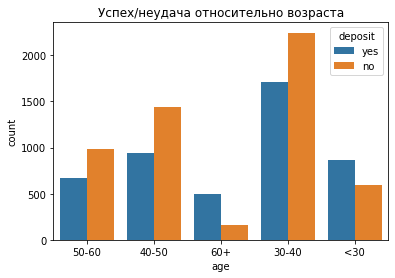

In [ ]:
countplot = sns.countplot(x='age', hue='deposit', data=cleaned)
countplot.set_title('Успех/неудача относительно возраста');

### Задания 9 и 10

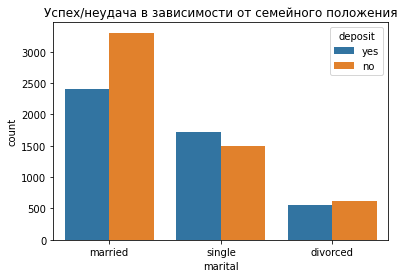

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
countplot = sns.countplot(x='marital', hue='deposit', data=cleaned)
countplot.set_title('Успех/неудача в зависимости от семейного положения');

In [ ]:
cleaned['marital'].value_counts()

married     5715
single      3213
divorced    1177
Name: marital, dtype: int64

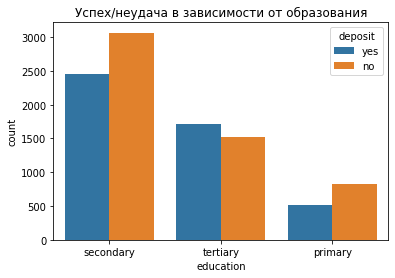

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
countplot = sns.countplot(x='education', hue='deposit', data=cleaned)
countplot.set_title('Успех/неудача в зависимости от образования');

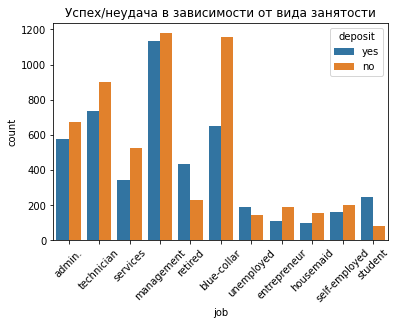

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
countplot = sns.countplot(x='job', hue='deposit', data=cleaned)
countplot.set_title('Успех/неудача в зависимости от вида занятости')
countplot.xaxis.set_tick_params(rotation=45);

### Задание 11

In [ ]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
deposited = cleaned[cleaned['deposit'] == 'yes']
depositless = cleaned[cleaned['deposit'] == 'no']

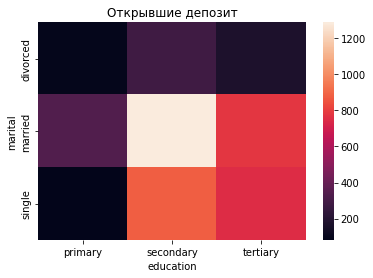

In [ ]:
pivot_yes = deposited.pivot_table(values='deposit', columns='education', index='marital', aggfunc='count')
heatmap = sns.heatmap(pivot_yes)
heatmap.set_title('Открывшие депозит');

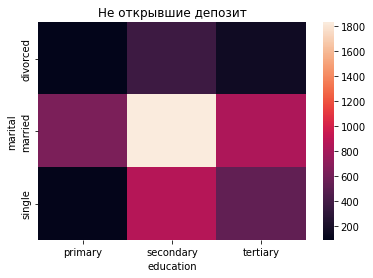

In [ ]:
pivot_no = depositless.pivot_table(values='deposit', columns='education', index='marital', aggfunc='count')
heatmap = sns.heatmap(pivot_no)
heatmap.set_title('Не открывшие депозит');

## Часть 3: преобразование данных

### Задание 1

In [ ]:
# преобразуйте уровни образования
le = LabelEncoder()
cleaned_le = le.fit_transform(cleaned['education'])
cleaned= cleaned.drop(labels=['education'], axis=1) 
cleaned_le = pd.DataFrame(cleaned_le, columns=['education'], index=cleaned.index)
cleaned = pd.concat([cleaned, cleaned_le], axis=1) 
cleaned.education.sum()

11995

In [ ]:
# обработаем по такому же принципу порядковую переменную для возраста.
cleaned_le = le.fit_transform(cleaned['age'])
cleaned= cleaned.drop(labels=['age'], axis=1) 
cleaned_le = pd.DataFrame(cleaned_le, columns=['age'], index=cleaned.index)
cleaned = pd.concat([cleaned, cleaned_le], axis=1)

### Задания 2 и 3

In [ ]:
# для вычисления стандартного отклонения по преобразованной в корректный вид целевой переменной deposit, применим LabelEncoder к переменной deposit
cleaned_le = le.fit_transform(cleaned['deposit'])
cleaned= cleaned.drop(labels=['deposit'], axis=1) 
cleaned_le = pd.DataFrame(cleaned_le, columns=['deposit'], index=cleaned.index)
cleaned = pd.concat([cleaned, cleaned_le], axis=1) 
round(cleaned.deposit.std(), 3)

0.499

In [ ]:
# преобразуйте бинарные переменные в представление из нулей и единиц
cleaned['default'] = cleaned['default'].apply(lambda x: 1 if x == 'yes' else 0)
cleaned['housing'] = cleaned['housing'].apply(lambda x: 1 if x == 'yes' else 0)
cleaned['loan'] = cleaned['loan'].apply(lambda x: 1 if x == 'yes' else 0)

n_43 = cleaned['default'].mean() + cleaned['housing'].mean() + cleaned['loan'].mean()
round(n_43, 3)

0.635

### Задание 4

In [ ]:
# создайте дамми-переменные
cat_features = ['job', 'marital', 'contact', 'month', 'poutcome']
cleaned = pd.get_dummies(cleaned, columns=cat_features)
# при применении pd.get_dummies() кодируемые признаки удаляются, прибавим их к количеству получившихся после применения столбцов (+5)
cleaned.shape[1]+5

50

### Задания 5 и 6

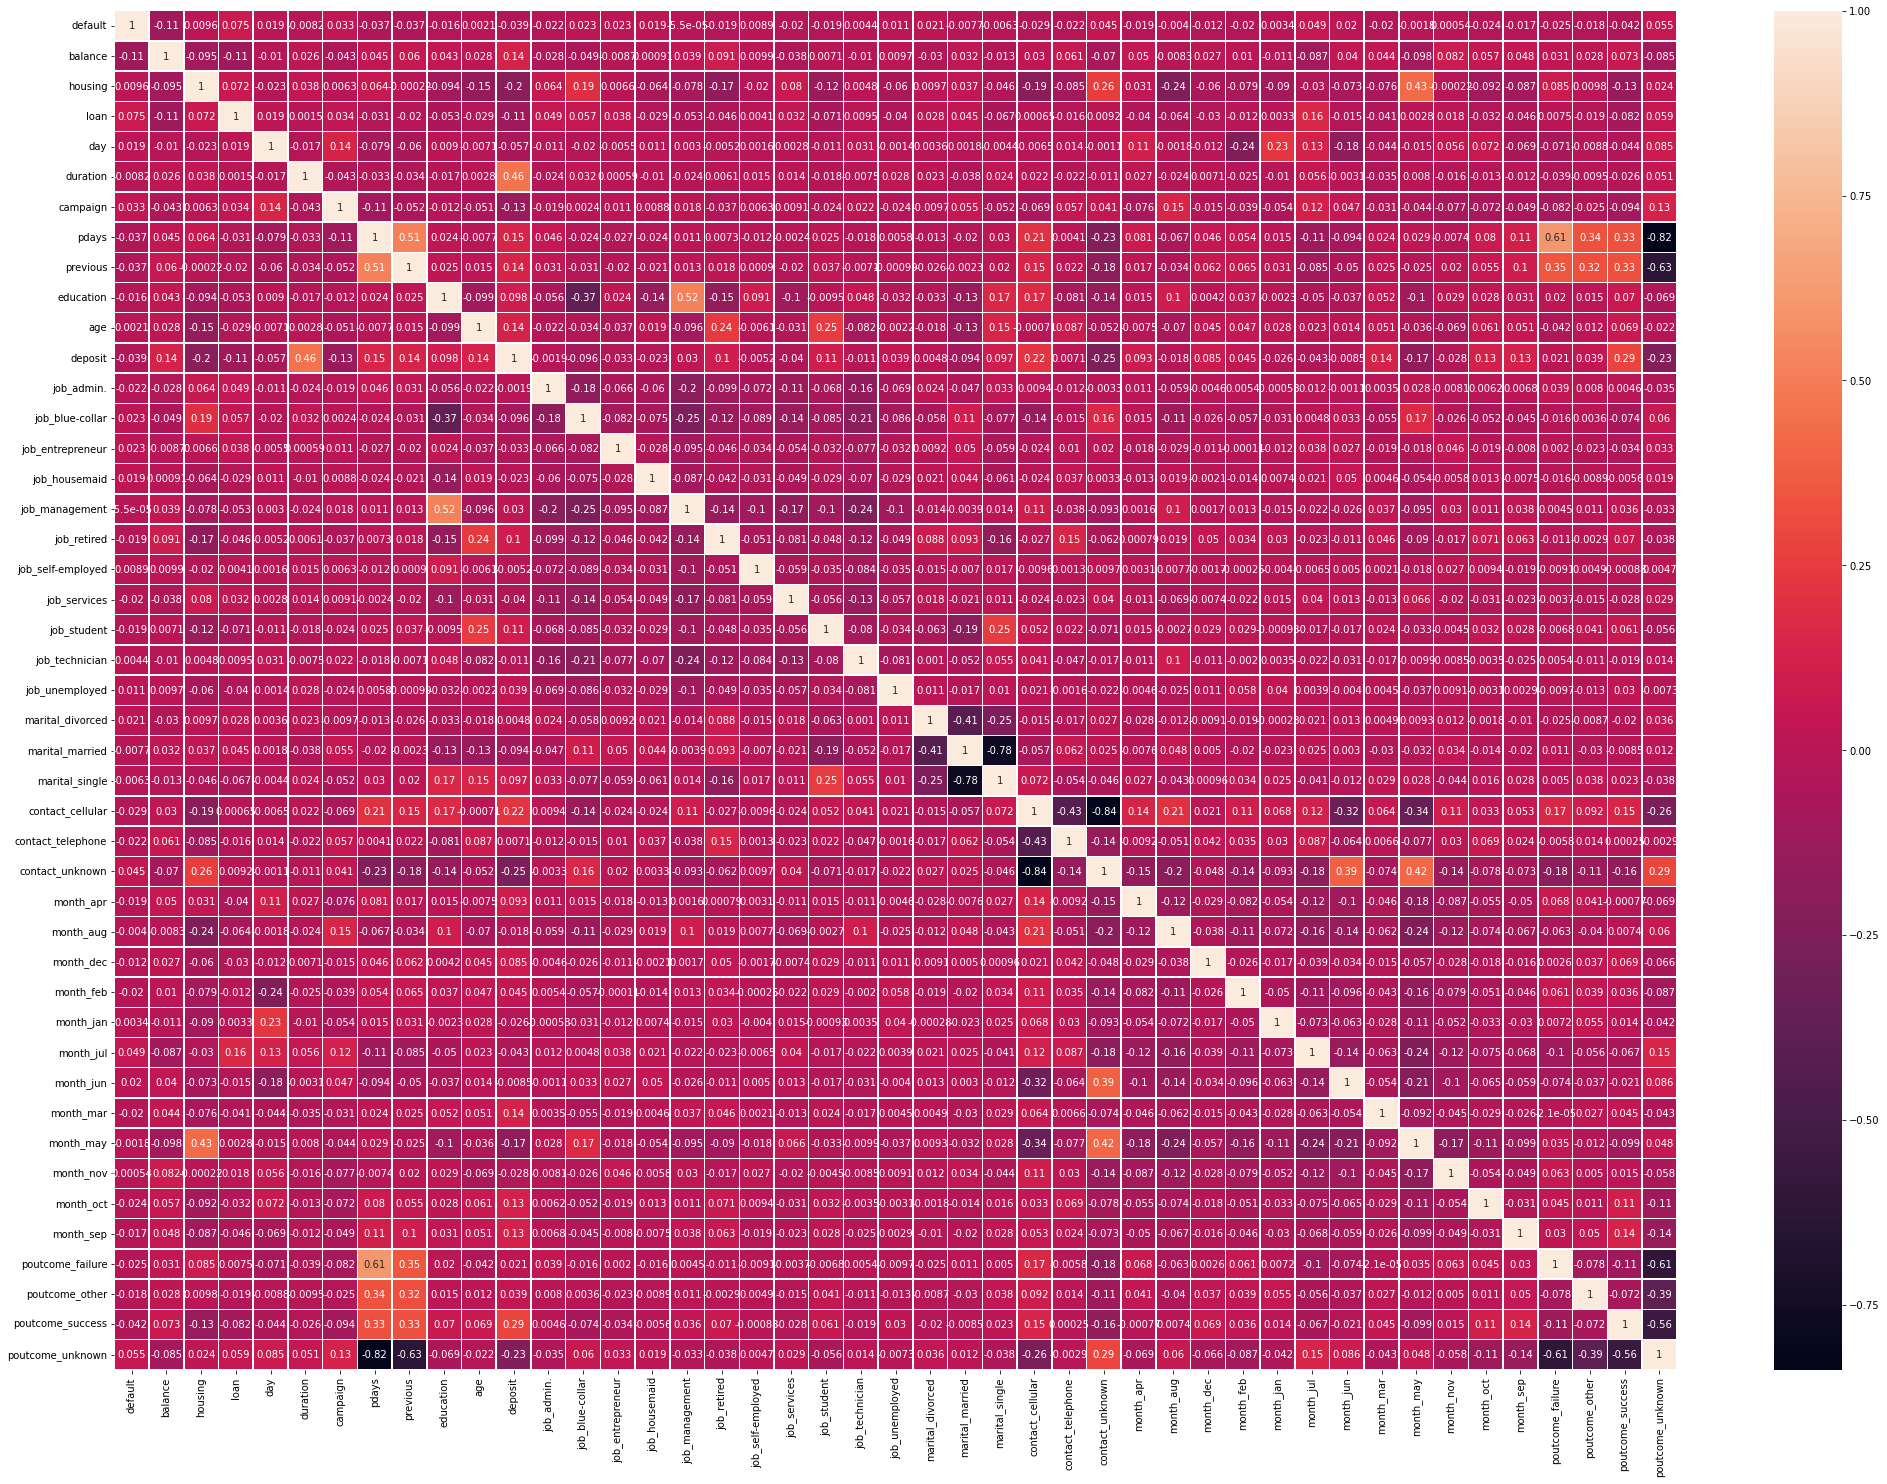

In [ ]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

fig, ax = plt.subplots(figsize=(35,25))
sns.heatmap(cleaned.corr(), annot=True, linewidths=.5, ax=ax);

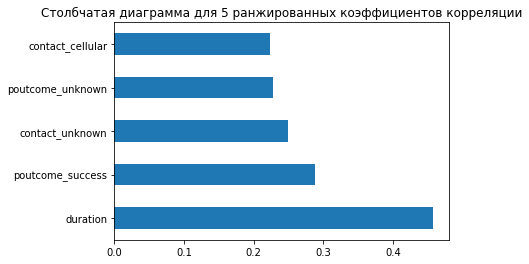

In [ ]:
# В качестве дополнения визуализации к этому заданию постройте столбчатую диаграмму для ранжированных коэффициентов корреляции.
cl = cleaned.corr() 
mask = cl.index  != 'deposit'
cl[mask]['deposit'].abs().sort_values(ascending=False)[0:5].plot.barh()
plt.title('Столбчатая диаграмма для 5 ранжированных коэффициентов корреляции')
plt.show();

### Задания 7 и 8

In [ ]:
X = cleaned.drop(['deposit'], axis=1)
y = cleaned['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [ ]:
# рассчитайте необходимые показатели
print(X_test.shape[0]) 
print(round(y_test.mean(), 2))

3335
0.46


### Задание 9

In [ ]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
# создаем селектор, обучаем на тренировочных выборках (.fit()), отбираем признаки (.get_feature_names_out())
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
selected_features = selector.get_feature_names_out()
X_train = X_train[selected_features]
X_test = X_test[selected_features]

### Задание 10

In [ ]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()

scaler.fit(X_train)
train_mm = scaler.transform(X_train)
test_mm = scaler.transform(X_test)

X_train_mm = pd.DataFrame(train_mm, columns=selected_features)
X_test_mm = pd.DataFrame(test_mm, columns=selected_features)

round(X_test_mm[X_test_mm.columns[0]].mean(), 2)

0.47

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [ ]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_reg = linear_model.LogisticRegression(random_state=42, solver='sag', max_iter=1000)
log_reg.fit(X_train_mm, y_train)
y_train_lr_pred = log_reg.predict(X_train_mm)
y_test_lr_pred = log_reg.predict(X_test_mm)

In [ ]:
print(round(metrics.accuracy_score(y_train, y_train_lr_pred), 2))
print(round(metrics.accuracy_score(y_test, y_test_lr_pred), 2))

0.82
0.8


### Задания 2,3,4

In [ ]:
# обучите решающие деревья, настройте максимальную глубину
dt_clf = tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=6)
dt_clf.fit(X_train_mm, y_train)
y_dt_train_pred = dt_clf.predict(X_train_mm)
y_dt_test_pred = dt_clf.predict(X_test_mm)
print(metrics.classification_report(y_train, y_dt_train_pred))
print(metrics.classification_report(y_test, y_dt_test_pred))

              precision    recall  f1-score   support

           0       0.86      0.79      0.82      3634
           1       0.78      0.85      0.81      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.82      0.82      6770
weighted avg       0.82      0.82      0.82      6770

              precision    recall  f1-score   support

           0       0.85      0.78      0.81      1790
           1       0.77      0.84      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335



### Задание 5

In [ ]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV
param_grid = {'min_samples_split': [2, 5, 7, 10],'max_depth':[3,5,7]}
grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=7,
    n_jobs = -1
)
%time grid_search.fit(X_train_mm, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test_mm, y_test)))
y_test_pred = grid_search.predict(X_test_mm)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: user 360 ms, sys: 66.5 ms, total: 427 ms
Wall time: 3.32 s
accuracy на тестовом наборе: 0.81
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 2}



# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [ ]:
# обучите на ваших данных случайный лес
rf_clf = ensemble.RandomForestClassifier(n_estimators = 100, criterion = 'gini', min_samples_leaf = 5, max_depth = 10, random_state = 42)
rf_clf.fit(X_train_mm, y_train)
y_train_pred = rf_clf.predict(X_train_mm)

#Выводим отчет о метриках
print(metrics.classification_report(y_train, y_train_pred))

y_test_pred = rf_clf.predict(X_test_mm)
print(round(metrics.accuracy_score(y_test, y_test_pred), 2))
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      3634
           1       0.84      0.86      0.85      3136

    accuracy                           0.86      6770
   macro avg       0.86      0.86      0.86      6770
weighted avg       0.86      0.86      0.86      6770

0.83
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

In [ ]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gb_clf = ensemble.GradientBoostingClassifier(learning_rate = 0.05, n_estimators = 300, min_samples_leaf = 5, max_depth = 5, random_state = 42)
gb_clf.fit(X_train_mm, y_train)

y_train_pred = gb_clf.predict(X_train_mm)

#Выводим отчет о метриках
print(metrics.classification_report(y_train, y_train_pred))

y_test_pred = gb_clf.predict(X_test_mm)
print(round(metrics.f1_score(y_test, y_test_pred), 2))
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      3634
           1       0.87      0.89      0.88      3136

    accuracy                           0.89      6770
   macro avg       0.89      0.89      0.89      6770
weighted avg       0.89      0.89      0.89      6770

0.82
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 4

In [ ]:
# объедините уже известные вам алгоритмы с помощью стекинга 
estimators = [('dt', tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=6)), 
              ('lr', linear_model.LogisticRegression(random_state=42, solver='sag', max_iter=1000)),
              ('gb', ensemble.GradientBoostingClassifier(learning_rate = 0.05, n_estimators = 300, min_samples_leaf = 5, max_depth = 5, random_state = 42))
              ]
clf = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=6)
)
clf.fit(X_train_mm, y_train)
y_stack_t_pred = clf.predict(X_train_mm)
y_stack_pred = clf.predict(X_test_mm)
print(metrics.classification_report(y_train, y_stack_t_pred))
print(round(metrics.precision_score(y_train, y_stack_t_pred), 2))
print(metrics.classification_report(y_test, y_stack_pred))
print(round(metrics.precision_score(y_test, y_stack_pred), 2))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      3634
           1       0.86      0.86      0.86      3136

    accuracy                           0.87      6770
   macro avg       0.87      0.87      0.87      6770
weighted avg       0.87      0.87      0.87      6770

0.86
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335

0.81


### Задание 5

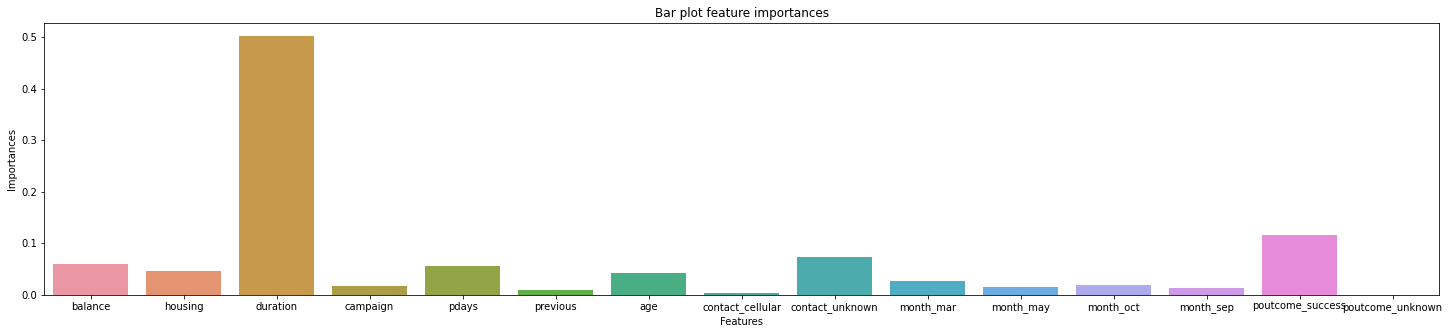

In [ ]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
fig, ax = plt.subplots(figsize=(25, 5)) #фигура + координатная плоскость
feature = X_test_mm.columns #признаки
feature_importances = gb_clf.feature_importances_ #важность признаков
#Строим столбчатую диаграмму
sns.barplot(x=feature, y=feature_importances, ax=ax);
#Добавляем подпись графику, осям абсцисс и ординат
ax.set_title('Bar plot feature importances')
ax.set_xlabel('Features')
ax.set_ylabel('Importances');

### Задания 6,7,8

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 5.0 MB/s 
     |████████████████████████████████| 81 kB 5.2 MB/s 
     |████████████████████████████████| 209 kB 28.7 MB/s 
     |████████████████████████████████| 78 kB 7.4 MB/s 
     |████████████████████████████████| 147 kB 76.7 MB/s 
     |████████████████████████████████| 49 kB 6.2 MB/s 
     |████████████████████████████████| 112 kB 59.6 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=a8a4abe4915ce7f02b2346c25159d9f1fb78b4298caf4cd144cc949704e2d2f6
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_mm, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_mm))

  return score


# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2022-09-10 15:19:32,562] A new study created in memory with name: RandomForestClassifier
[I 2022-09-10 15:19:33,838] Trial 0 finished with value: 0.8452119309262166 and parameters: {'n_estimators': 195, 'max_depth': 23, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8452119309262166.
[I 2022-09-10 15:19:34,764] Trial 1 finished with value: 0.8581704456606725 and parameters: {'n_estimators': 143, 'max_depth': 26, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.8581704456606725.
[I 2022-09-10 15:19:35,532] Trial 2 finished with value: 0.8777292576419214 and parameters: {'n_estimators': 110, 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.8777292576419214.
[I 2022-09-10 15:19:37,164] Trial 3 finished with value: 0.8533416810142432 and parameters: {'n_estimators': 199, 'max_depth': 13, 'min_samples_leaf': 7}. Best is trial 2 with value: 0.8777292576419214.
[I 2022-09-10 15:19:38,385] Trial 4 finished with value: 0.8606957342987563 and parameters: {'n

In [ ]:
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 166, 'max_depth': 30, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.92


In [ ]:
model = ensemble.RandomForestClassifier(**study.best_params, random_state=42)
model.fit(X_train_mm, y_train)
y_test_pred = model.predict(X_train_mm)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_mm, y_test)))
y_test_pred = model.predict(X_test_mm)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.82
f1_score на тестовом наборе: 0.82
